<a href="https://colab.research.google.com/github/tejas5t6/project-using-cnn/blob/main/cats_vs_dog_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🔧 Training model from scratch using MobileNetV2...


/tmp/ipython-input-1248971962.py:39: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.8015 - loss: 0.4060 - val_accuracy: 0.8940 - val_loss: 0.2531
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.9385 - loss: 0.1501 - val_accuracy: 0.9090 - val_loss: 0.2240
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.9675 - loss: 0.1028 - val_accuracy: 0.9158 - val_loss: 0.2195
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.9814 - loss: 0.0628 - val_accuracy: 0.9212 - val_loss: 0.2177
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9941 - loss: 0.0341 - val_accuracy: 0.9280 - val_loss: 0.2217


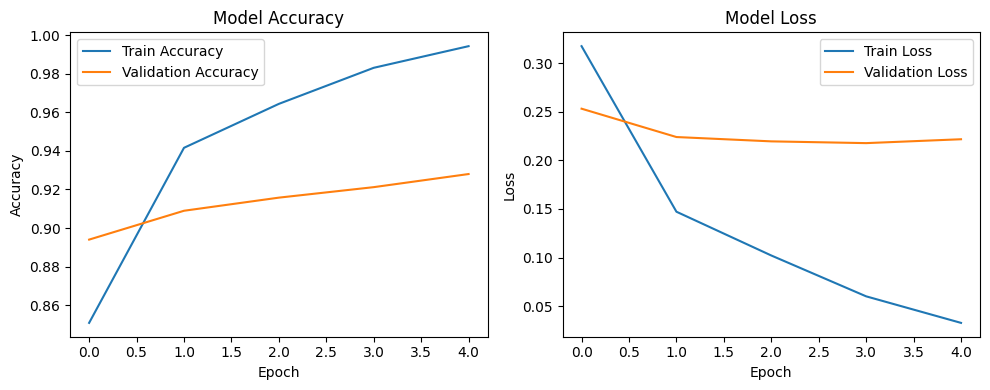

✅ Model saved to Drive.
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9c2414ef5679bea2df.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [3]:

!pip install tensorflow tensorflow-datasets gradio --quiet


import tensorflow as tf
import tensorflow_datasets as tfds
import gradio as gr
import os
import matplotlib.pyplot as plt


from google.colab import drive
drive.mount('/content/drive')

model_path = "/content/drive/MyDrive/cat_dog_mobilenetv2_model.h5"


def preprocess_binary(image, label):
    is_dog = tf.cast(label >= 12, tf.int64)
    image = tf.image.resize(image, (180, 180))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, is_dog


(train_ds, val_ds), info = tfds.load(
    'oxford_iiit_pet',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

train_ds = train_ds.map(preprocess_binary).shuffle(1000).batch(32).prefetch(1)
val_ds = val_ds.map(preprocess_binary).batch(32).prefetch(1)


if not os.path.exists(model_path):
    print("🔧 Training model from scratch using MobileNetV2...")

    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(180, 180, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


    history = model.fit(train_ds, validation_data=val_ds, epochs=5)


    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

    model.save(model_path)
    print("✅ Model saved to Drive.")
else:
    print("📁 Loading model from Drive...")
    model = tf.keras.models.load_model(model_path)
    print("✅ Model loaded.")


def predict_image(img):
    img = tf.image.resize(img, (180, 180))
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    img = tf.expand_dims(img, 0)
    pred = float(model.predict(img)[0][0])
    if abs(pred - 0.5) < 0.2:
        return "❌ Invalid image (not a cat or dog)"
    label = "Dog 🐶" if pred > 0.5 else "Cat 🐱"
    confidence = pred if pred > 0.5 else 1 - pred
    return f"✅ {label} ({confidence * 100:.1f}% confidence)"


gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="numpy", label="Take or Upload Image", sources=["upload", "webcam"]),
    outputs=gr.Textbox(label="Prediction"),
    title="Cat vs Dog Classifier 🐾",
    description="Webcam enabled | Model saved to Google Drive"
).launch()
